In [ ]:
# 匯入套件
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 下載資料集
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# 檢視資料集的shape
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


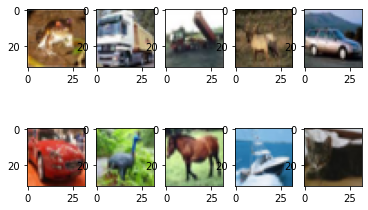

In [ ]:
# 檢視前10筆訓練樣本
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [ ]:
# 檢視前10筆訓練標籤
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# 檢視經過預處理資料的shape
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
# 建構卷積層
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=True,
        kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [ ]:
# 建構殘差塊 A
def first_residual_unit(filters, strides):
    def f(x):
        # → BN → ReLU
        x = BatchNormalization()(x)
        x_b = Activation('relu')(x)

        # 卷積層 → BN → ReLU
        x = conv(filters // 4, 1, strides)(x_b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 卷積層 → BN → ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # 卷積層→
        x = conv(filters, 1)(x)

        # 調整捷徑之 shape 的尺寸
        x_b = conv(filters, 1, strides)(x_b)

        # Add
        return Add()([x, x_b])
    return f

In [ ]:
# 建構殘差塊 B
def residual_unit(filters):
    def f(x):
        x_b = x
        
        # → BN → ReLU
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 卷積層 → BN → ReLU
        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 卷積層 → BN → ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 卷積層 →
        x = conv(filters, 1)(x)

        # Add
        return Add()([x, x_b])
    return f

In [ ]:
# 建構殘差塊 A×1 與 殘差塊 B×17
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)
        for i in range(unit_size-1):
            x = residual_unit(filters)(x)
        return x
    return f

In [ ]:
# 輸入資料的 shape
input = Input(shape=(32,32, 3))

# 卷積層
x = conv(16, 3)(input)

# 殘差塊 x 54
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

# → BN → ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 池化層
x = GlobalAveragePooling2D()(x)

# 密集層
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# 建構模型
model = Model(inputs=input, outputs=output)

In [ ]:
# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [ ]:
# 設定 ImageDataGenerator
train_gen  = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    width_shift_range=0.125, 
    height_shift_range=0.125, 
    horizontal_flip=True)
test_gen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True)

for data in (train_gen, test_gen):
    data.fit(train_images)

In [ ]:
# 設定 LearningRateScheduler
def step_decay(epoch):
    x = 0.1
    if epoch >= 80: x = 0.01
    if epoch >= 120: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay,verbose = 1)

In [ ]:
# 訓練
batch_size = 128
history = model.fit(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=120,
    steps_per_epoch=train_images.shape[0] // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps=test_images.shape[0] // batch_size,
    callbacks=[lr_decay])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/120
390/390 [==============================] - 119s 304ms/step - loss: 4.3798 - acc: 0.3709 - val_loss: 4.7734 - val_acc: 0.3374

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/120
390/390 [==============================] - 116s 297ms/step - loss: 3.5953 - acc: 0.5470 - val_loss: 3.6663 - val_acc: 0.4925

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/120
390/390 [==============================] - 116s 298ms/step - loss: 3.0445 - acc: 0.6442 - val_loss: 2.8532 - val_acc: 0.6627

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/120
390/390 [==============================] - 116s 298ms/step - loss: 2.6129 - acc: 0.7079 - val_loss: 2.5447 - val_acc: 0.7024

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/120
390/390 [==============================] - 116s 298ms/step - loss: 2.2833 - acc: 0.7507 - val_loss: 2.319

In [ ]:
# 儲存模型
model.save('resnet.h5')

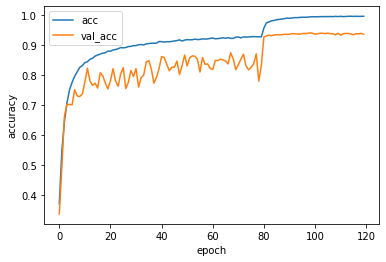

In [ ]:
# 繪製圖形
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# 評估
batch_size = 128
test_loss, test_acc = model.evaluate(
    test_gen.flow(test_images, test_labels, batch_size=batch_size))
    #,steps=test_images.shape[0] // batch_size)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

79/79 [==============================] - 7s 83ms/step - loss: 0.4518 - acc: 0.9362
loss: 0.452
acc: 0.936


In [ ]:
# 評估
test_loss, test_acc = model.evaluate(
    test_gen.flow(test_images, test_labels))
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

313/313 [==============================] - 8s 26ms/step - loss: 0.4518 - acc: 0.9362
loss: 0.452
acc: 0.936


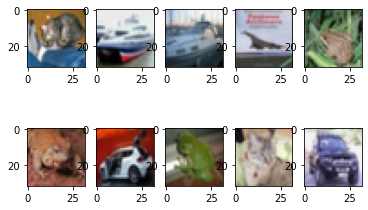

前 10 筆預測標籤: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']
前 10 筆原始標籤: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [ ]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

test_predictions = model.predict(test_gen.flow(test_images[0:10], shuffle = False))
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print('前 10 筆預測標籤:',[labels[n] for n in test_predictions])
test_ans = np.argmax(test_labels[:10], axis=1)
print('前 10 筆原始標籤:',[labels[n] for n in test_ans])